<a href="https://colab.research.google.com/github/UlyShel/basics_of_deep_learning/blob/main/HW2_ogo6_Shelegova_Ulyana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом по классификации emoji из тг. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 100 классов и около 100 картинок на каждый класс. Классы пронумерованы, кодом смайлика к которому относятся элементы класса. Скачать датасет можно вот [тут](https://disk.yandex.ru/d/elNF0DS94o2GVA).

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.4**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.8**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.4)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.4) / 0.4)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
val = '/content/drive/MyDrive/val.zip'
extract_val = '/content/drive/MyDrive/val_unzipped'
!unzip -q "{val}" -d "{extract_val}"

In [ ]:
train = '/content/drive/MyDrive/train.zip'
extract_train = '/content/drive/MyDrive/train_unzipped_1'
!unzip -q "{train}" -d "{extract_train}"

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 38.7 MB/s eta 0:00:00


**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from pytorch_lightning import Trainer

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать свою модель руками в классе YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
# https://pytorch.org/vision/main/transforms.html + на основе 3 семинара:

train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(p=0.5), #Horizontally flip the input with a given probability.
        torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2), #Randomly change the brightness, contrast, saturation and hue of an image or video.
        torchvision.transforms.RandomInvert(p=0.2), # Inverts the colors of the given image or video with a given probability.
        torchvision.transforms.ToTensor(), # картинки к формату тензор
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) # параметры - матожидание и дисперсия
    ]
)
val_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

In [ ]:
train_dataset = ImageFolder('/content/drive/MyDrive/train_unzipped_1/train', transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
val_dataset = ImageFolder('/content/drive/MyDrive/val_unzipped/val', transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

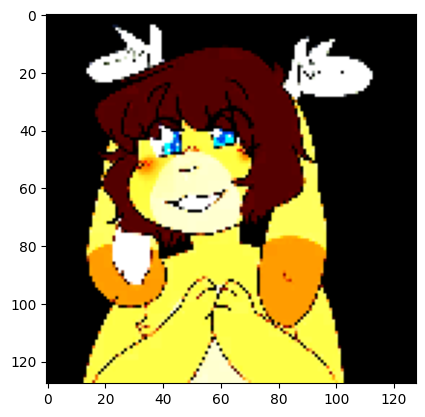

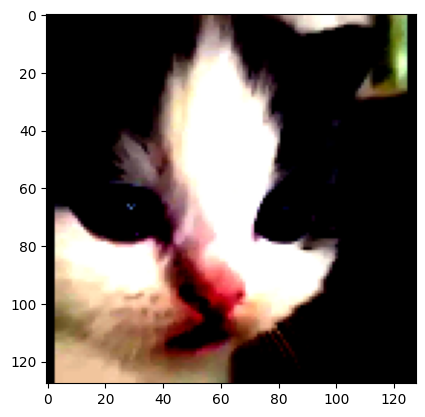

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.4. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
# я решала разными способами и решила почти все варианты оставить!

# 1 АРХИТЕКТУРА

# этот класс (определение модели) и следующий (обертка обучения) - на основе 4 семинара

class YourNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            self.relu,
            self.maxpool,
            torch.nn.BatchNorm2d(64)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            self.relu,
            self.maxpool,
            torch.nn.BatchNorm2d(128)
        )

        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=128 * 15 * 15, out_features=256)
        self.linear2 = torch.nn.Linear(in_features=256, out_features=64)
        self.output = torch.nn.Linear(in_features=64, out_features=100)

        self.dropout = torch.nn.Dropout(p=0.5)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

        self.accuracy_metric = Accuracy(task='multiclass', num_classes=100)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)

        return self.output(x)


    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = self.accuracy_metric(self.preds.long(), self.targets.long())

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

        self.best_accuracy = 0.0
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=100)

        # https://docs.wandb.ai/guides/integrations/lightning
        self.save_hyperparameters()

    def forward(self, x, target=None):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch

        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True, on_epoch=True
        )

        preds = torch.argmax(self.model._forward(images), dim=-1)
        train_acc = self.accuracy_metric(preds, target)
        self.log("train_acc", train_acc, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch

        loss_val = self.model(images, target)
        self.log("val_loss", loss_val, prog_bar=True, on_epoch=True)
        preds = torch.argmax(self.model._forward(images), dim=-1)

        val_acc = self.accuracy_metric(preds, target)
        self.log("val_acc", val_acc, on_epoch=True, prog_bar=True)
        if val_acc > self.best_accuracy:
           self.best_accuracy = val_acc

        return loss_val


    # https://github.com/matterport/Mask_RCNN/issues/751
    def on_epoch_end(self):
        print(f"Epoch: {self.current_epoch + 1}: Best val_accuracy: {self.best_accuracy:.4f}")


In [ ]:
# https://docs.wandb.ai/guides/integrations/lightning
wandb.init(project="HW2_1_task")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

wandb: Currently logged in as: ushelegova (ushelegova-hse). Use `wandb login --relogin` to force relogin


In [ ]:
model = YourNet().to(device)
module = YourModule(model)

In [ ]:
# https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.LearningRateFinder.html

from pytorch_lightning.callbacks import LearningRateFinder

class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, trainer, pl_module):
        pass

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)

seed_everything(123456)

trainer = Trainer(
    logger=wandb_logger,
    callbacks=[FineTuneLearningRateFinder(milestones=[5, 10])],
    min_epochs=1,
    max_epochs=50,
    limit_train_batches=0.2,
    deterministic=True
)

#https://github.com/Lightning-AI/pytorch-lightning/issues/15247

trainer.fit(module, train_dataloader, val_dataloader)
trainer.save_checkpoint("1task_checkpoint.ckpt")
wandb.finish()

# # НИЖЕ: это я так проверяла, работает ли модель

# # https://discuss.pytorch.org/t/how-to-get-a-part-of-datasets/82161
# # https://stackoverflow.com/questions/47432168/taking-subsets-of-a-pytorch-dataset

# trainer1 = Trainer(
#     logger=wandb_logger,
#     callbacks=[FineTuneLearningRateFinder(milestones=[5, 10])],
#     min_epochs=1,
#     max_epochs=5,
#     limit_train_batches=1.0
# )

# indices = torch.randperm(len(train_dataset))[:20]
# indices_2 = torch.randperm(len(val_dataset))[:10]
# trainset_1 = torch.utils.data.Subset(train_dataset, indices)
# train_dataloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=4,
#                                             shuffle=True, num_workers=2)

# valset_1 = torch.utils.data.Subset(val_dataset, indices_2)
# val_dataloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=4,
#                                             shuffle=False, num_workers=2)

# trainer1.fit(module, train_dataloader_1, val_dataloader_1)
# trainer1.save_checkpoint("fignya.ckpt")

# wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | model           | YourNet            | 7.5 M  | train
1 | accuracy_metric | MulticlassAccuracy | 0      | train
---------------------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.959    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.3981071705534969
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_106ac2a2-bd02-43b0-bf0f-abcd55b421a4.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_106ac2a2-bd02-43b0-bf0f-abcd55b421a4.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/training_epoch_loop.py:161: You're resuming from a checkpoint that ended before the epoch ended and your dataloader is not resumable. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or make your dataloader resumable by implementing the `state_dict` / `load_state_dict` interface.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 81 steps due to diverging loss.
ERROR:pytorch_lightning.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b221c986-b6e6-463c-bce1-99f1205d30f6.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_b221c986-b6e6-463c-bce1-99f1205d30f6.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 171 steps due to diverging loss.
ERROR:pytorch_lightning.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_78b718f3-8e5e-4629-b35a-f407fdf481c4.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_78b718f3-8e5e-4629-b35a-f407fdf481c4.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Модель оказалась слабовая (**лучшая accuracy - 0.146**) + закончилось гпу (слишком много эпох, видимо), и я поняла, что нужно пробовать готовые архитектуры.

**ВАНДБ**:

https://wandb.ai/ushelegova-hse/HW2_1_task/reports/val_acc-24-11-01-23-50-19---Vmlldzo5OTg4Nzgy?accessToken=bt19buct4w956dqtyz153y78juokpqby7qyxl89d2w0lxwh660uupp3da0zuypb1

In [ ]:
from torchvision.models import resnet18
from torchmetrics.functional import accuracy

In [ ]:
# 2 АРХИТЕКТУРА - резнет18 (на основе семинара 4)
class Resnet(pl.LightningModule):
    def __init__(self, pretrained: bool = False, lr=0.001) -> None:
        super().__init__()
        self.pretrained = pretrained
        self.lr = lr

        if pretrained:
            self.model = resnet18(pretrained=True)
            self.model.fc = nn.Identity()
            self.classifier = nn.Linear(512, 100)
            self.optimizer = torch.optim.Adam(self.classifier.parameters())

        else:
            self.model = resnet18(pretrained=False)
            self.model.fc = nn.Linear(self.model.fc.in_features, 100)
            self.optimizer = torch.optim.Adam(self.model.parameters())  # в качестве оптимизатора сразу взяла сразу Адам

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        if self.pretrained:
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True,  on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'multiclass', num_classes=100)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("accuracy", acc, prog_bar=True, on_epoch=True)

In [ ]:
wandb.init(project="HW2_1_task_resnet")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

wandb: Currently logged in as: ushelegova (ushelegova-hse). Use `wandb login --relogin` to force relogin


In [ ]:
resnet_model = Resnet(pretrained=False)

from pytorch_lightning.callbacks import LearningRateFinder

class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, trainer, pl_module):
        pass

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)

seed_everything(123456)

trainer_resnet = Trainer(
    accelerator="auto",
    logger=wandb_logger,
    callbacks=[FineTuneLearningRateFinder(milestones=[5, 10])],
    min_epochs=1,
    max_epochs=50,
    # limit_train_batches=0.3,
    deterministic=True
)

trainer_resnet.fit(resnet_model, train_dataloader, val_dataloader)
trainer_resnet.save_checkpoint("1task_checkpoint_2.ckpt")
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instan

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0007585775750291836
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_31bd6c04-a270-405c-a1f0-663e9024129f.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_31bd6c04-a270-405c-a1f0-663e9024129f.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/training_epoch_loop.py:161: You're resuming from a checkpoint that ended before the epoch ended and your dataloader is not resumable. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or make your dataloader resumable by implementing the `state_dict` / `load_state_dict` interface.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 441 steps due to diverging loss.
ERROR:pytorch_lightning.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_0c4bb327-35c0-4e28-9049-c066b967c006.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_0c4bb327-35c0-4e28-9049-c066b967c006.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 891 steps due to diverging loss.
ERROR:pytorch_lightning.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f9de3443-aaa5-4b8b-b25e-cdb88bb32f1d.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f9de3443-aaa5-4b8b-b25e-cdb88bb32f1d.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

**Получилось выбить 0.2308**, а потом на 35 эпохе кончилось ГПУ.. и у меня не успела сохраниться модель, поэтому я не могу ее лоаднуть, но вот ссылка на **вандб**!! пожалуйста, поверьте мне..

https://wandb.ai/ushelegova-hse/HW2_1_task_resnet/reports/accuracy-24-11-05-13-56-16---VmlldzoxMDAzNDQxNQ?accessToken=8yqh5qfhbiw3lixkqpztfnqj4sk75hu0us8f9jezjzah4hb82tpchxb3513w80bg

это я на случай, если дальше лучше не будет, ведь я все равно не смогу ниже валидацию прогнать

In [ ]:
from torchvision.models import resnet50

# 3 АРХИТЕКТУРА - резнет50 (я подумала, что гулять так гулять)

class Resnet50(pl.LightningModule):
    def __init__(self, pretrained: bool = False, lr=0.0007585775750291836) -> None:
      # взяла lr с предыдущего задания
        super().__init__()
        self.pretrained = pretrained
        self.lr = lr

        if pretrained:
            self.model = resnet50(pretrained=True)
            self.model.fc = nn.Identity()
            self.classifier = nn.Linear(512, 100)
            self.optimizer = torch.optim.AdamW(self.classifier.parameters())

        else:
            self.model = resnet50(pretrained=False)
            self.model.fc = nn.Linear(self.model.fc.in_features, 100)
            self.optimizer = torch.optim.AdamW(self.model.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        if self.pretrained:
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = model(images)
        loss = model.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True,  on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'multiclass', num_classes=100)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("accuracy", acc, prog_bar=True, on_epoch=True)

In [ ]:
wandb.init(project="HW2_1_task_resnet_2")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

accuracy,▁▄▅▆█
epoch,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇█
train_loss_epoch,█▄▂▂▁
train_loss_step,██▆▆▅▇▅▃▆▁
trainer/global_step,▁▂▂▂▃▃▃▃▄▄▄▅▆▆▆▆▇▇▇█
val_loss,█▁▁▁▁
accuracy,0.1624
epoch,5
train_loss_epoch,3.49609
train_loss_step,3.40603
trainer/global_step,499


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
# https://github.com/Lightning-AI/pytorch-lightning/issues/596

resnet_model_2 = Resnet50(pretrained=False)

# сохраняю после каждой 5 эпохи сразу, чтобы все внезапно не вылетело (я еще параллельно с этим скачивала чекпоинты)
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    filename='resnet_epoch_{epoch}',
    save_top_k=-1,
    every_n_epochs=5
)

seed_everything(123456)

trainer_resnet = Trainer(
    accelerator="auto",
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    min_epochs=1,
    max_epochs=30,
    precision=16,
    deterministic=True
)

trainer_resnet.fit(resnet_model_2, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 23.7 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
23.7 M    Trainable params
0         Non-trainable params
23.7 M    Total params
94.852    Total estimated model params size (MB)
152  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


У этой модели не удалось переплюнуть предыдущую, но по крайней мере я зафиксировала чекпоинты и выбрала лучший (**0.226**)! в случае если ничего не выйдет выбить больше, вернусь к ним + сразу прогнала через формулу определения оценки (ниже)

**ВАНДБ** - https://api.wandb.ai/links/ushelegova-hse/rxi0o6uv

In [ ]:
# 4 АРХИТЕКТУРА - решила вернуться к резнету18, как к самой удачной архитектуре, но при этом зафиксировала лернинг рейт, который я уже подобрала

class resnet18_2(pl.LightningModule):
    def __init__(self, pretrained: bool = False, lr=0.0007585775750291836) -> None:

        super().__init__()
        self.pretrained = pretrained
        self.lr = lr

        if pretrained:
            self.model = resnet18(pretrained=True)
            self.model.fc = nn.Identity()
            self.classifier = nn.Linear(512, 100)
            self.optimizer = torch.optim.Adam(self.classifier.parameters())

        else:
            self.model = resnet18(pretrained=False)
            self.model.fc = nn.Linear(self.model.fc.in_features, 100)
            self.optimizer = torch.optim.Adam(self.model.parameters())

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=100, task='multiclass')

    def forward(self, x) -> torch.Tensor:

        if self.pretrained:
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            preds = self.model(x)
        return preds

    def configure_optimizers(self):

        optimizer = self.optimizer

        # https://github.com/Lightning-AI/pytorch-lightning/discussions/15744
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=3,
            mode = 'max',
            verbose=True
        )

        return {
           'optimizer': optimizer,
           'scheduler': scheduler,
           'monitor': 'accuracy'
       }


    def training_step(self, train_batch, batch_idx) -> torch.Tensor:

        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:

        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = self.accuracy(preds, target)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("accuracy", acc, prog_bar=True, on_epoch=True)

In [ ]:
wandb.init(project="HW2_1_task_resnet18_2")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

wandb: Currently logged in as: ushelegova (ushelegova-hse). Use `wandb login --relogin` to force relogin


In [ ]:
# в этот раз обучаюсь аккуратнее, чтобы случайно все не вылетело, как в прошлый раз

resnet18_model_2 = resnet18_2(pretrained=False)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    filename='resnet_epoch_{epoch}',
    save_top_k=-1,
    every_n_epochs=5
)

seed_everything(123456)

trainer_resnet = Trainer(
    accelerator="auto",
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    min_epochs=1,
    max_epochs=25, #25 эпох, а не 50 хахахах
    precision=16,
    deterministic=True
)
trainer_resnet.fit(resnet18_model_2, train_dataloader, val_dataloader)

wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.ra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


accuracy,▁▃▃▃▄▄▄▅▅▆▅▇▅▇▅▆▆▆▆▇▆▆▇▇█
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_loss_epoch,████▇▇▇▇▇▇▆▆▆▅▅▅▄▃▃▂▂▂▁▁▁
train_loss_step,████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▄▃▃▂▂▂▁▁▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
val_loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▅▅▆▇▇█▇
accuracy,0.2204
epoch,24
train_loss_epoch,0.23153
train_loss_step,0.56347
trainer/global_step,2249


Accuracy - **0.2204**

**ВАНДБ** -  https://wandb.ai/ushelegova-hse/HW2_1_task_resnet18_2/reports/accuracy-24-11-05-13-15-22---VmlldzoxMDAzMzY4NQ?accessToken=7t7zfrog12865ti6kagt3w2n9gg1kuytd8wi7b70osxo3p66j2jde4o1oss5giep

In [ ]:
wandb.init(project="HW2_1_task_resnet18_2")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# доучиваю другим шедулером

from torch.optim.lr_scheduler import CosineAnnealingLR
checkpoint_path = 'checkpoints/resnet_epoch_epoch=24.ckpt'
resnet_new = resnet18_2.load_from_checkpoint(checkpoint_path)

model_instance = resnet18_2()

resnet_new.lr_scheduler = CosineAnnealingLR(model_instance.optimizer, T_max=7)

trainer_resnet = Trainer(
    accelerator="auto",
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    min_epochs=1,
    max_epochs=7, # доучиваю 7 эпохами
    precision=16,
    deterministic=True,
    enable_checkpointing=True,
)

trainer_resnet.fit(resnet_new, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | loss     | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


accuracy,▇▄▇▆▁▇█
epoch,▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇████
train_loss_epoch,█▆▅▆▄▃▁
train_loss_step,▇██▃▄█▄▃▇▄▁▃
trainer/global_step,▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
val_loss,▁▄▄▆▇█▆
accuracy,0.2236
epoch,6
train_loss_epoch,0.11468
train_loss_step,0.11982
trainer/global_step,629


Accuracy действительно немножко повысилось - **0.2236** Видимо на послдених эпохах полезно повышать и снижать lr поочереди

**ВАНДБ** - https://wandb.ai/ushelegova-hse/HW2_1_task_resnet18_2/reports/accuracy-24-11-05-13-14-15---VmlldzoxMDAzMzY2NA?accessToken=dlazf2hn4vx2iulkd1jg6til1mj9m15o6npq5mgxc5d750gqw46qbqr439m9zxyq

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            preds = model(images)
            acc_batch = model.accuracy(torch.argmax(preds, dim=-1), labels)
        accuracy += acc_batch.item()
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
# итог на резнет-50 (как и обещала)
model1 = Resnet50.load_from_checkpoint('/content/checkpoints/resnet_epoch_epoch=24.ckpt')

accuracy = evaluate_task(model1, val_dataloader)
print(f"\n\nОценка за это задание составит {np.clip(5 * accuracy / 0.24, 0, 5):.2f} баллов")

100%|██████████| 5/5 [00:10<00:00,  2.18s/it]



Оценка за это задание составит 3.99 баллов


In [ ]:
# ИТОГОВОЫЙ ИТОГ НА РЕЗНЕТЕ-18 (засчитайте это, пожалуйста!!)
# почему я взяла не дообученный резнет? я его запускала через функцию, но балл был ниже за него, поэтоум я оставила исходный

model1 = resnet18_2.load_from_checkpoint('/content/checkpoints/resnet_epoch_epoch=24.ckpt')

accuracy = evaluate_task(model1, val_dataloader)
print(f"\n\nОценка за это задание составит {np.clip(5 * accuracy / 0.24, 0, 5):.2f} баллов")


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]



Оценка за это задание составит 4.56 баллов


Для того, чтобы решить это задание я переключалась между 5 гугл аккаунтами и даже такой итог уже хорош, но было бы здорово, если бы мне накинули чуть-чуть поинтов за 1 модель резнет, которая выдала 2.308 (график еще раз: https://www.google.com/url?q=https%3A%2F%2Fapi.wandb.ai%2Flinks%2Fushelegova-hse%2F1e48esr3)

это не идеально, но я старалась!

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.8. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры лучше используйте Adam c параметрами по умолчанию как стартовую точку.
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(p=0.5), #Horizontally flip the input with a given probability.
        torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2), #Randomly change the brightness, contrast, saturation and hue of an image or video.
        torchvision.transforms.ToTensor(), # картинки к формату тензор
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # параметры - матожидание и дисперсия
    ]
)
val_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)
train_dataset_pretrained = ImageFolder('/content/drive/MyDrive/train_unzipped_1/train', transform=train_transform)
train_dataloader_pretrained = DataLoader(train_dataset_pretrained, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)

val_dataset_pretrained = ImageFolder('/content/drive/MyDrive/val_unzipped/val', transform=val_transform)
val_dataloader_pretrained = DataLoader(val_dataset_pretrained, batch_size=512, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
assert isinstance(train_dataset_pretrained[0], tuple)
assert len(train_dataset_pretrained[0]) == 2
assert isinstance(train_dataset_pretrained[1][1], int)
print("tests passed")

tests passed


In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fc34102a52f49b2832106072b8869813eebe1b2df05e86ec8475c261a20bf024
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

# я не сразу обучалась эфишент нетом, на самом деле я пробовала и резнет-18, и резнет-50
# резнет-18 почти не обучался (я уже горадо позже прочитала, что стоило уменьшить шаг в несколько раз, я думаю, это связано с тем, что готовые веса может очень сильно шатать)
# резнет-50 не грузился.. мб у меня к тому моменту закончилсоь гпу, но мне кажется, это еще из-за того, что архитектура очень сложная

# но в целом я выбрала efficientnet, потому что на многих сайт пишут, что зачастую именно эта архитектура работает лучше на много-классовой классификации, поэтому я решила подстраховаться
# https://www.sciencedirect.com/science/article/pii/S1877050924006768
# https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://viso.ai/deep-learning/efficientnet/%23:~:text%3DFor%2520example%252C%2520EfficientNet%252DB0%2520achieves,parameters%2520(%252066M%2520vs%2520557M).&ved=2ahUKEwjU0LrX_sSJAxW7GRAIHQNxFTIQFnoECBoQAw&usg=AOvVaw1AdKIycURUVTBL4895T5EU

class efficientnet_pretrained(pl.LightningModule):
    def __init__(self, pretrained: bool = True, numclasses=100, lr=0.0007585775750291836) -> None:

        super().__init__()
        self.pretrained = pretrained
        self.lr = lr

        if pretrained:
          self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=100)
        else:
          EfficientNet.from_name('efficientnet-b0', num_classes=100) # решила взять b0 как самый простой и быстрый вариант архитектуры из efficientnet

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr) # adamW аж взяла

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=100, task='multiclass')

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        optimizer = self.optimizer

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=3,
            mode='max',
            verbose=True
        )

        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
            'monitor': 'accuracy'
        }

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("trainloss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = self.accuracy(preds, target)
        self.log("valloss", loss, prog_bar=True, on_epoch=True)
        self.log("accuracy", acc, prog_bar=True, on_epoch=True)

In [ ]:
wandb.init(project="HW2_task2_eff")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

accuracy,▁█
epoch,▁▁▁████
trainer/global_step,▁▃▃▄▆██
trainloss_epoch,█▁
trainloss_step,█▁▁
valloss,█▁
accuracy,0.2728
epoch,1
trainer/global_step,179
trainloss_epoch,2.82168
trainloss_step,2.77855


In [ ]:
efficientnet_model = efficientnet_pretrained(pretrained=True)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    filename='efficientnet_epoch_{epoch}',
    save_top_k=-1,
    every_n_epochs=5
)

seed_everything(123456)

trainer = Trainer(
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    min_epochs=1,
    max_epochs=10, # боялась, что с такой сложной моделью и оптимизатором все накроется, поэтоум взяла мало эпох
    precision=16,
    deterministic=True
)

trainer.fit(efficientnet_model, train_dataloader_pretrained, val_dataloader_pretrained)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is dep

Loaded pretrained weights for efficientnet-b0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Я ОБАЛДЕЛА!! это очень хорошо!!!

**accuracy** - 0.3232

**вандб** - https://api.wandb.ai/links/ushelegova-hse/xg49u5nq

In [ ]:
wandb.init(project="HW2_task2_eff_new")
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

epoch,▁
trainer/global_step,▁
trainloss_step,▁
epoch,0
trainer/global_step,49
trainloss_step,0.67153


Я ДОУЧИВАЛА 3 РАЗА в одной и той же ячейке, но случайно удалила сам запуск (ну это некритично, учитывая то, что я ничего не меняла, просто перезапускала с разных чекпоинтов)..

ЛУЧШАЯ accuracy - **0.3436**

**ВАНДБ** - https://wandb.ai/ushelegova-hse/HW2_task2_eff_new/reports/accuracy-24-11-05-13-42-52---VmlldzoxMDAzNDIwOA?accessToken=beeaxxlbcf0s8c8evzm04c2olw2l008to436ys0h7119xnenao7ucydkp9bqnf2r


был еще такой промежуточный: https://wandb.ai/ushelegova-hse/HW2_task2_eff/reports/accuracy-24-11-05-13-44-34---VmlldzoxMDAzNDIzOA?accessToken=a5okzjmdcu0piroooz8c228ysb459yn5j6hqut0urf0xbhixqbi8dbiieeabtptr

### Валидация результатов задания

МОЙ ПРОГРЕСС ЗАПУСКОВ:

In [ ]:
model = efficientnet_pretrained.load_from_checkpoint('/content/checkpoints/efficientnet_epoch_epoch=9.ckpt')

accuracy = evaluate_task(model, val_dataloader_pretrained)
print(f"Оценка за это задание составит {np.clip(5 * (accuracy - 0.1) / 0.24, 0, 5):.2f} баллов")

Loaded pretrained weights for efficientnet-b0



100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

Оценка за это задание составит 4.76 баллов


In [ ]:
model = efficientnet_pretrained.load_from_checkpoint('/content/checkpoints/eff2_epoch_epoch=3.ckpt')

accuracy = evaluate_task(model, val_dataloader_pretrained)
print(f"Оценка за это задание составит {np.clip(5 * (accuracy - 0.1) / 0.24, 0, 5):.2f} баллов")

Loaded pretrained weights for efficientnet-b0


100%|██████████| 5/5 [00:11<00:00,  2.40s/it]

Оценка за это задание составит 4.89 баллов


In [ ]:
model = efficientnet_pretrained.load_from_checkpoint('/content/checkpoints/eff2_epoch_epoch=3-v1.ckpt')

accuracy = evaluate_task(model, val_dataloader_pretrained)
print(f"Оценка за это задание составит {np.clip(5 * (accuracy - 0.1) / 0.24, 0, 5):.2f} баллов")

Loaded pretrained weights for efficientnet-b0



100%|██████████| 5/5 [00:11<00:00,  2.26s/it]

Оценка за это задание составит 5.00 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

В принципе выше я уже все написала (**смотрите выше, я после каждого запуска все ссылки оставляла**). Здесь оставлю только  **итоговые графики, которые помогли выбить максимум**

**1 задание**:

- *0.2236* https://www.google.com/url?q=https%3A%2F%2Fwandb.ai%2Fushelegova-hse%2FHW2_1_task_resnet18_2%2Freports%2Faccuracy-24-11-05-13-14-15---VmlldzoxMDAzMzY2NA%3FaccessToken%3Ddlazf2hn4vx2iulkd1jg6til1mj9m15o6npq5mgxc5d750gqw46qbqr439m9zxyq
- или если вы мне засчитаете **без графика функции evaluation**: *0.2308* https://www.google.com/url?q=https%3A%2F%2Fwww.google.com%2Furl%3Fq%3Dhttps%253A%252F%252Fapi.wandb.ai%252Flinks%252Fushelegova-hse%252F1e48esr3

**2 задание**: *0.3436* https://www.google.com/url?q=https%3A%2F%2Fwandb.ai%2Fushelegova-hse%2FHW2_task2_eff_new%2Freports%2Faccuracy-24-11-05-13-42-52---VmlldzoxMDAzNDIwOA%3FaccessToken%3Dbeeaxxlbcf0s8c8evzm04c2olw2l008to436ys0h7119xnenao7ucydkp9bqnf2r
